## **Code Readability Score**



In [ ]:
import numpy as np #Linear algebra library
import os #Used to manipulate local file system to access the dataset data
import copy #Used for copy.deepcopy to copy matrices to get new ones with the same dimensions 
import matplotlib.pyplot as plt #Used to plot the cost function against time for the network.
import csv #Used to parse the csv files containing the data
import re #Used to manipulate the snippets by splitting on punctuation in order to get identifiers out

### Process Snippet Data


In [ ]:
def SnippetsToFeatures():
    """Takes snippets from the Dorn readability dataset which are already saved locally and processes them into a set of machine learning features."""
    
    X_DIRECTORY = "/content/drive/MyDrive/A Level/Computer Science/NEA/Readability Data"  #The local directory containing all of the snippets
    Y_FILE = "/content/drive/MyDrive/A Level/Computer Science/NEA/Readability Data/python.csv" #The csv file containing ratings for each snippet

    #Initialise matrices for total rating and no of times rated (to compute averages)
    y = np.zeros((1,len(os.listdir(X_DIRECTORY))-1))
    noRatings = np.zeros((1,len(os.listdir(X_DIRECTORY))-1))

    #Open the csv file and iterate over it
    with open(Y_FILE) as csv_file: #Source https://realpython.com/python-csv/
        yData = csv.reader(csv_file, delimiter=',')
        for row in yData: #Each row represents one person who rated snippets; each column is one snippet. Each row contains a large number of blank cells (unrated snippets) and a few data cells
            for i,value in enumerate(row[1:]): #for each snippet the user rated (skipping first column which is uid)
                if value != "": #if the user did rate the snippet
                    y[0][i] += int(value) #add the rating and count the number of ratings so we can average later
                    noRatings[0][i] += 1
    
    y /= noRatings #average
    
    #The ratings were 1 to 5 inclusive. Convert to be from 0 to 10 which is what we want for our output
    y -= 1 
    y *= 10/4

    #Now we have all of the average ratings, for every snipppet get the snippet and extract features and then put the snippet next to its rating in the matrix
    for i,file in enumerate(os.listdir(X_DIRECTORY)): #for every file in the directory that stores them
        if os.path.splitext(file)[1] == '.jsnp': #if the file has the correct extension it must be a snippet file
            with open(os.path.join(X_DIRECTORY,file)) as f: #read the file contents before passing it into the ExtractCodeReadabilityFeatures routine
                if i == 0: #For the first one we need to create the dataMatrix variable as the result ...
                    dataMatrix = ExtractCodeReadabilityFeatures(f.read())
                else:
                    dataMatrix = np.hstack((dataMatrix,ExtractCodeReadabilityFeatures(f.read()))) #... and for subsequent ones we need to stack the results horizontally next to the existing dataMatrix
    dataMatrix = np.vstack((dataMatrix,y)) #Now put the y values on the bottom so each row represents an x or y feature and each column represents one input snippet training example.
    
    return dataMatrix #output data matrix back to caller.

def ExtractCodeReadabilityFeatures(codeSnippet):
    """Takes a code snippet and converts it to a matrix of statistical features describing it, which will be used to score it on readability."""
    
    #These are used to determine whether a word seen in the code snippet is an identifier or a language keyword
    LANGUAGE_KEYWORDS = ["for","if","def","lambda","while","await","else","elif","import","pass","break","except","in","raise","class","finally","is","return","and","continue","try","as","from","assert","del","global","not","with","async","or","yield","self","False","True","AttributeError","None"] #Source https://www.programiz.com/python-programming/keyword-list 
    
    #MAINTENANCE: To change the designated tab style (tabs/spaces) for this part of the solution, swap the commented line
    TAB_CHAR = "    "
 #   TAB_CHAR = "\t" 
    
    #Initialise accumulator variables counting each feature which will later be averaged.
    numberOfLines = 0    
    totalLineLength = 0
    totalEmptyLines = 0
    maxIndentDepth = 0
    totalDigits = 0
    totalSpaces = 0
    prevIndent = 0
    blockLength = 0
    totalBlockLength = 0 
    totalBlocks = 0 
    totalIdentifiers = 0
    totalIdentifierLength = 0
    totalCamelPascal = 0
    totalUnder = 0
    totalUpperCase = 0 
    idCounts = {} #This dictionary counts occurrences of each identifier in the code snippet so we can later calculate things like the number of occurrences of the most frequent identifier

    for line in codeSnippet.split("\n"): #Go over every line in the snippet
        numberOfLines += 1 #Count lines
        totalLineLength += len(line) #This variable will later be divided by numberOfLines to get averageLineLength
        if line == "": #Count empty lines
            totalEmptyLines += 1
            continue #Skip further processing on empty lines

        if line.count(TAB_CHAR) > maxIndentDepth: #One of the features is the maximum indentation depth in tabs (or multiples of 4 spaces)
            maxIndentDepth = line.count(TAB_CHAR)
        
        totalDigits += sum([line.count(a) for a in "1234567890"]) #Count all digits in the line
        totalSpaces += line.count(" ") #Count all spaces in the line

        if line.count(TAB_CHAR) != prevIndent: #prevIndent stores the indent level of the previous line, so that we know if indentation has changed (if yes we are on a new block of code)
            totalBlockLength += blockLength #We will later divide this by total blocks to get average block length
            blockLength = 0
            totalBlocks += 1
        prevIndent = line.count(TAB_CHAR) #this line's indent is saved for next time
        blockLength += 1 

        #We take the part of the current line up to any comment (# or """) and split it on punctuation, yielding only "words". These are either identifiers or keywords
        for item in re.split("\W+",line.split("#")[0].split("\"\"\"")[0]): #https://stackoverflow.com/questions/1059559/split-strings-into-words-with-multiple-word-boundary-delimiters
            if item == "": #There were two symbols in a row, yielding a blank match which we ignore
                continue
            if not(item in LANGUAGE_KEYWORDS): #Not a language keyword therefore...
                #item is an identifier name
                totalIdentifiers += 1 #Count identifiers
                totalIdentifierLength += len(item) #Will be used to get average identifier length
                
                #Count different variable naming conventions
                if "_" in item: #underscore_based
                    totalUnder += 1
                if re.search("[A-Z]",item) and re.search("[a-z]",item): #camelCase/PascalCase
                    totalCamelPascal += 1
                elif re.search("[A-Z]",item): #UPPER CASE
                    totalUpperCase += 1
                
                #Increment the number of times we have seen this identifier in the code so we can later find the maximum occurrences of a single identifier
                if item in idCounts:
                    idCounts[item] = idCounts[item] + 1 
                else:
                    idCounts[item] = 1
    
    totalSharpComments = codeSnippet.count("#")

    #Avoid divide by 0 errors
    if totalIdentifiers == 0:
        totalIdentifiers = 1
    if totalBlocks == 0:
        totalBlocks = 1

    #Compute averages
    averageLineLength = totalLineLength/numberOfLines
    averageIdentifierLength = totalIdentifierLength/totalIdentifiers
    averageIdPerLine = totalIdentifiers/numberOfLines
    averageSharpCommentsPerLine = totalSharpComments/numberOfLines
    averageEmptyLinesPerLine = totalEmptyLines/numberOfLines
    averageCamelPascalPerLine = totalCamelPascal/numberOfLines
    averageUnderPerLine = totalUnder/numberOfLines
    averageCapsPerLine = totalUpperCase/numberOfLines
    averageDigitsPerLine = totalDigits/numberOfLines
    averageSpacesPerLine = totalSpaces/numberOfLines
    averageBlockLength = totalBlockLength/totalBlocks

    #Get maximum occurrence of any identifier
    if len(idCounts) > 0: #If we have at least one identifier, sort the identifiers and then get the last (maximum as ascending) one
        maximumOccurOfID = idCounts[sorted(idCounts, key=idCounts.get)[-1]] #Source: https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
    else:
        maximumOccurOfID = 0 #There were no identifiers. We deal with this case separately because otherwise we get an index error on the [-1] above
    
    #Count remaining things to count and average over number of lines so we don't penalise long code
    #   List of regular expressions to match e.g. comparison operators, bitwise operators, assignment,  arithmetic
    THINGS_TO_LOOK_FOR = ["<|>|==|<=|>=","\^|\~|\&|\|","[^=]=[^=]","\+|\-|\/|\*","\,","\.","for","if|elif|else","def","lambda","while","pass","break","except","in","raise","class","finally","is","return","and","continue","try","as","from","assert","del","global","not","with","async","or","yield","\@","print"]
    ##THINGS_TO_LOOK_FOR = ["<|>|==|<=|>=","\^|\~|\&|\|","[^=]=[^=]","\+|\-|\/|\*","\,","\.","for","if|elif|else","def","lambda","while","pass","break|continue","try|except|finally","raise","class","assert","global","with"]
    #THINGS_TO_LOOK_FOR = ["<|>|==|<=|>=","[^=]=[^=]","\+|\-|\/|\*","\,","\.","for","if|elif|else","def"]#"lambda","while"] #,"pass","break","except","in","raise","class","finally","is","return","and","continue","try","as","from","assert","del","global","not","with","async","or","yield","\@","print"]

    #Initialise the matrix of features we will store everything in
    N_FEATURES = 13 + len(THINGS_TO_LOOK_FOR)
    xFeatures = np.zeros((N_FEATURES,1))

    for i,item in enumerate(THINGS_TO_LOOK_FOR): #Search for each thing and fill up the features matrix
        xFeatures[i][0] = len(re.findall(item, codeSnippet))/numberOfLines #One feature is the amount of times each of the THINGS_TO_LOOK_FOR appears in the code, on average per line 
    
    #Save remaining features
    xFeatures[i+1] = averageLineLength
    xFeatures[i+2] = averageIdentifierLength
    xFeatures[i+3] = averageIdPerLine
    xFeatures[i+4] = averageSharpCommentsPerLine
    xFeatures[i+5] = averageEmptyLinesPerLine
    xFeatures[i+6] = averageCamelPascalPerLine
    xFeatures[i+7] = averageUnderPerLine
    xFeatures[i+8] = averageCapsPerLine
    xFeatures[i+9] = averageDigitsPerLine
    xFeatures[i+10] = averageSpacesPerLine
    xFeatures[i+11] = maximumOccurOfID
    xFeatures[i+12] = averageBlockLength
    xFeatures[i+13] = maxIndentDepth
    
    return xFeatures #Just the xFeatures are computed here and returned to caller. In data preparation for training, the caller will add the y label to train on, but in the live IDE the y label will be predicted by the readability features model.

np.set_printoptions(suppress=True) #Turn off scientific notation
datasetMatrix = SnippetsToFeatures() #get data out
np.save("/content/drive/MyDrive/A Level/Computer Science/NEA/ReadabilityFeatures.npy",datasetMatrix) #Save as numpy binary for later import into Python code
print("Saved as NPY")

Saved as NPY


### Train and Use Neural Network

In [ ]:
DATA_LOCATION ="/content/drive/MyDrive/A Level/Computer Science/NEA/ReadabilityFeatures.npy" #The location of the feature array for the readability dataset
features = np.load(DATA_LOCATION)
X = features[:-1,:]
Y = features[-1,:].reshape((1,X.shape[1]))

#Randomly re-order the dataset. (https://stackoverflow.com/questions/20546419/shuffle-columns-of-an-array-with-numpy) 
np.random.seed(1234)
order = np.random.permutation(X.shape[1]) #Get a permutation of numbers which defines in what order we will put the dataset
X = X[:, order] #Make sure to reorder both X and Y in the same way so that the labels still match their partner features.
Y = Y[:, order]

np.save("/content/drive/MyDrive/A Level/Computer Science/NEA/ReadabilityX.npy",X) #Save randomly shuffled data as numpy binary for later import into Python code
np.save("/content/drive/MyDrive/A Level/Computer Science/NEA/ReadabilityY.npy",Y) #This is important as it means we can separately run this part of the code to reshuffle the dataset but we don't have to run it when training, meaning we can easily compare hyperparameter values as the training set is constant.

In [ ]:
def tanh(matrix):
    """The hyperbolic tangent activation function. Used as the default activation for all layers except the last one here"""
    return (np.exp(matrix) - np.exp(-matrix))/(np.exp(matrix)+np.exp(-matrix))

def tanh_prime(matrix):
    """Derivative of the hyperbolic tangent activation function with respect to the input matrix"""
    return 1-np.square(tanh(matrix))

def relu(matrix):
    "Rectified linear units activation function"
    return np.maximum(matrix,np.zeros(matrix.shape))

def relu_prime(matrix): 
    """Derivative of ReLU with respect to matrix"""
    return np.vectorize(lambda z : 1 if z >=0 else 0)(matrix)

def sigmoid(matrix):
    """Sigmoid activation function"""
    return 1/(1+np.exp(-matrix))

def sigmoid_prime(matrix):
    """Sigmoid activation function derivative"""
    return sigmoid(matrix)*(1-sigmoid(matrix))

def forwardProp(X,Ws,bs): 
    """Performs 1 forward propagation through the network to get a readability rating for given X (input features - each column is one training example so vectorised), Ws (list of weights), bs (list of biases)"""
    As = [X] #Activations at each layer, with layer 0 having the input features as its activations
    Zs = [] #Z values (input to the activation function === matrix product of Ws[current layer] and a[layer before] + bs[current layer])
    
    for i in range(len(Ws)-1): #For every layer in the network except the last one, which is dealt with separately as it has a different activation,
        Zs.append(np.matmul(Ws[i],As[i]) + bs[i]) #Compute the next Z value by multiplying the corresponding weights with the previous layer's activations and adding the biases
        As.append(sigmoid(Zs[-1])) #Compute this layer's activation by applying the tanh activation function

    #Forward prop the final layer
    Z_final = np.matmul(Ws[-1],As[-1]) + bs[-1] #Compute Z as usual 
    Zs.append(Z_final) #Save the final Z value
    As.append(Z_final) #No final activation function as we just want to do regression.
    return Zs,As #Return the Z and Activation values, which will be needed for backprop 

def getCodeReadabilityScore(featureMatrix,Ws,bs):
    """Runs forward propagation on the network with the provided weights and input features and returns the final layer activations, the scores for each code sample"""
    Zs, As = forwardProp(featureMatrix,Ws,bs)
    return As[-1] #===y_hat

def accuracyMetrics(X,Ws,bs,Y):
    """Calculate some accuracy metrics on the test data to check how good the learning algorithm is."""
    Y_hat = getCodeReadabilityScore(X,Ws,bs)
    Y_hat *= sigmaY
    Y_hat += muY
    Y *= sigmaY
    Y += muY
    print("Y")
    print(Y)
    print("Y_hat") 
    print(Y_hat)
    print("Diffs")
    print(Y-Y_hat)
    print("Mean diff")
    print(np.mean(np.abs(Y-Y_hat)))

def computeCost(X,Ws,bs,Y,lamd):
    """Computes the neural network cost function for the parameters Ws (weights), bs (biases) on input X and ground truth labels Y. lamd is the regularisation parameter lambda"""
    Zs,As = forwardProp(X,Ws,bs) #Perform forward propagation to get the Zs and As. We will need to pass these back to the calling code for backprop
    Y_hat = As[-1] #Precicted scores 
    m = Y.shape[1] #Number of training examples (needed as we average the cost over all training examples)
    J = 1/m * np.sum(np.square(Y-Y_hat)) + lamd/(2*m)*sum([np.sum(np.square(w)) for w in Ws]) #MSE for regression with Frobenius norm regularisation (results in a scalar value - the smaller the value the better the neural network is doing)
    return J,Zs,As #Cost, Zs, Activations

def train(X,Ws,bs,Y,iter,alpha,lamd):
    """Train a deep neural network with initial parameters Ws, bs, for iter iterations, with input features X and ground truth labels Y, with batch gradient descent (learning rate alpha) and weight decay regularisation parameter lamd"""
    Js = [] #We will save the costs on each iteration to be able to plot them later to see that they are decreasing monotonically
    CVJs = []
    m = Y.shape[1] #Number of training examples

    for i in range(iter): #For each iteration, perform forward prop, get cost, perform backprop by gradient descent and update weights
        costCV,_,_ = computeCost(cvX,Ws,bs,cvY,lamd)
        cost,Zs,As = computeCost(X,Ws,bs,Y,lamd)
        CVJs.append(costCV)
        Js.append(cost)

        dZ = -2*(Y-As[-1]) #Derivative of the cost function with respect to the final layer logits Z 
        dWs = copy.deepcopy(Ws) #The derivatives of the cost function with respect to each layer's weights..
        dbs = copy.deepcopy(bs) #...and biases. We use copy to initialise a dummy list of matrices with the correct dimensions although the values will be replaced - the W and dW values are not the same
        
        for backwardLayer in range(len(As)-2,-1,-1): #Move backward through the network, starting at the second to last set of activations
            dWs[backwardLayer] = 1/m*np.matmul(dZ,As[backwardLayer].T) + lamd/m*Ws[backwardLayer] #Compute the partial derivative with respect to the cost function J of the weights at this layer
            dbs[backwardLayer] = 1/m*np.sum(dZ,axis=1,keepdims=True) #Compute the partial derivative with respect to the cost function J of the biases at this layer
            
            if backwardLayer != 0: #If we are not back at the start of the network, then there is at least one more iteration (set of dW and db values to compute) and so we need to compute the parital derivative of J with respect to the next set of Z values, since this is used to compute the next layer's dW and db
                dZ = np.matmul(Ws[backwardLayer].T,dZ)*sigmoid_prime(Zs[backwardLayer-1])

        for i in range(len(Ws)): #Apply gradients via gradient descent to update the weights so that they hopefully get it right next time
            Ws[i] = Ws[i] - alpha*dWs[i]
            bs[i] = bs[i] - alpha*dbs[i]

    plt.ylim(0, 6)
    plt.plot(Js) #debug plot of the cost function with iterations to check it is monotonically increasing
    plt.plot(CVJs)
    plt.title("Neural Network Cost Function with iterations of gradient descent")
    return Ws,bs #Trained weights and biases go back to calling code

In [ ]:
X = np.load("/content/drive/MyDrive/A Level/Computer Science/NEA/ReadabilityX.npy") #Load in the X and Y values from where they are stored
Y = np.load("/content/drive/MyDrive/A Level/Computer Science/NEA/ReadabilityY.npy")

n_X = X.shape[0] #The number of input features.

#Normalise features to have 0 mean and 1 standard deviation
np.set_printoptions(suppress=True) #Turn off scientific notation
mu = np.mean(X,axis=1).reshape(n_X,1)
sigma = np.std(X,axis=1).reshape(n_X,1)
for i in range(sigma.shape[0]):
    if sigma[i,0] == 0:
        sigma[i,0] = 1 #Some rows have 0 standard deviation which leads to division by zero error so just make the standard deviation 1 for now 
X -= mu
X /= sigma

print(Y)
muY = np.mean(Y)
sigmaY = np.std(Y)
Y -= muY
Y /= sigmaY
print(Y)

#Split the dataset into train, cross-validation and test sets
PERCENTAGE_TRAIN = 0.7 
PERCENTAGE_CV = 0.15
NUMBER_TRAIN = round(PERCENTAGE_TRAIN * X.shape[1])
NUMBER_CV = round(PERCENTAGE_CV * X.shape[1])

trainX = X[:,:NUMBER_TRAIN]
cvX = X[:,NUMBER_TRAIN:NUMBER_TRAIN+NUMBER_CV]
testX = X[:,NUMBER_TRAIN+NUMBER_CV:]

trainY = Y[:,:NUMBER_TRAIN]
cvY = Y[:,NUMBER_TRAIN:NUMBER_TRAIN+NUMBER_CV]
testY = Y[:,NUMBER_TRAIN+NUMBER_CV:]


m = trainX.shape[1] #Number of examples in training set

[[4.3989071  8.19736842 5.84975369 6.89473684 5.951417   6.62857143
  5.95108696 5.83333333 4.65277778 5.00961538 6.28698225 6.80962343
  7.35714286 7.78205128 8.01020408 7.32804233 7.08333333 5.90517241
  4.08613445 4.93811881 6.27118644 5.40178571 6.98412698 6.69421488
  7.8957529  6.73553719 6.812749   3.92011834 6.96351931 6.00896861
  5.04237288 6.40167364 8.2486631  6.98979592 6.21010638 5.84661355
  3.22972973 7.44877049 6.03293413 5.01004016 4.6        7.78074866
  6.125      7.93859649 7.68918919 5.87837838 6.29781421 7.42521368
  5.99710983 5.95430108 6.61392405 6.28140704 6.84357542 7.29700855
  7.02185792 5.03232759 4.93421053 6.36740331 5.18055556 5.28074866
  6.10406091 5.84355828 8.50980392 6.85555556 4.70588235 6.53846154
  7.35232068 6.56593407 5.86419753 6.99152542 5.25900901 7.05020921
  5.5995935  7.2361809  6.56578947 5.97826087 6.38554217 6.52663934
  7.1657754  4.85294118 5.94444444 5.31791908 7.47126437 6.22994652
  7.34304933 4.37739464 6.64473684 6.20454545 4.

Trained

Train set
Y
[[4.3989071  8.19736842 5.84975369 6.89473684 5.951417   6.62857143
  5.95108696 5.83333333 4.65277778 5.00961538 6.28698225 6.80962343
  7.35714286 7.78205128 8.01020408 7.32804233 7.08333333 5.90517241
  4.08613445 4.93811881 6.27118644 5.40178571 6.98412698 6.69421488
  7.8957529  6.73553719 6.812749   3.92011834 6.96351931 6.00896861
  5.04237288 6.40167364 8.2486631  6.98979592 6.21010638 5.84661355
  3.22972973 7.44877049 6.03293413 5.01004016 4.6        7.78074866
  6.125      7.93859649 7.68918919 5.87837838 6.29781421 7.42521368
  5.99710983 5.95430108 6.61392405 6.28140704 6.84357542 7.29700855
  7.02185792 5.03232759 4.93421053 6.36740331 5.18055556 5.28074866
  6.10406091 5.84355828 8.50980392 6.85555556 4.70588235 6.53846154
  7.35232068 6.56593407 5.86419753 6.99152542 5.25900901 7.05020921
  5.5995935  7.2361809  6.56578947 5.97826087 6.38554217 6.52663934
  7.1657754  4.85294118 5.94444444 5.31791908 7.47126437]]
Y_hat
[[4.38383937 8.18421841 5.8492

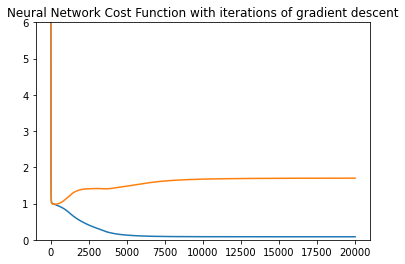

In [ ]:
NODES = [n_X,10,3,1] #This describes the architecture of the network (number of nodes in each layer). The activation functions are set elsewhere
NODES = [n_X,15,10,5,1] #This describes the architecture of the network (number of nodes in each layer). The activation functions are set elsewhere
NODES = [n_X,30,20,20,10,1] #This describes the architecture of the network (number of nodes in each layer). The activation functions are set else  0.31694589023189906where 1.1532639907258033

#Randomly initialise weights and biases for each layer
Ws = [] #Each value in this array is a numpy matrix representing the weights for the transition from a pair of consecutive layers. len(Ws) === len(nodes)-1
for i in range(len(NODES)-1):
    Ws.append(np.random.standard_normal((NODES[i+1],NODES[i])))
bs = []#Each value in this array is a numpy matrix representing the biases for the transition from a pair of consecutive layers. len(bs) === len(nodes)-1
for i in range(len(NODES)-1):
    bs.append(np.random.standard_normal((NODES[i+1],1)))

#MAINTENANCE: Network training constants - to improve performance of model try changing these and check train and cv set accuracy. Use test set to get a final unbiased estimate of how good the model is
NUM_ITER = 20000 #How many epochs to train for
ALPHA = 0.01 #Gradient descent learning rate
LAMBDA = 0 #Regularisation parameter 

trainedWs,trainedbs = train(trainX,Ws,bs,trainY,NUM_ITER,ALPHA,LAMBDA) #Train the network
print("Trained")
print("\nTrain set")
accuracyMetrics(trainX,trainedWs,trainedbs,trainY) #Compute accuracy metrics on the train set
print("\nCV set")
accuracyMetrics(cvX,trainedWs,trainedbs,cvY) #Compute accuracy metrics on the dev set

In [ ]:
np.save("/content/drive/MyDrive/A Level/Computer Science/NEA/ReadabilityWs.npy",trainedWs) #Save weights as numpy binary for later import into Python code
np.save("/content/drive/MyDrive/A Level/Computer Science/NEA/ReadabilityBs.npy",trainedbs) #Save biases as numpy binary for later import into Python code

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [ ]:
#Example code for loading in ws and bs to be used in the actual IDE code
w = np.load("/content/drive/MyDrive/A Level/Computer Science/NEA/ReadabilityWs.npy",allow_pickle=True)
b = np.load("/content/drive/MyDrive/A Level/Computer Science/NEA/ReadabilityBs.npy",allow_pickle=True)
accuracyMetrics(testX,w,b,testY)


Y
[[7.23463687 7.90983607 6.55487805 8.01136364 6.58959538 3.54700855
  7.74193548 6.09251969 6.04278075 4.81481481 6.73155738 7.90358744
  6.52083333 5.1863354  6.79956897 5.63577586 7.04787234 7.18879668]]
Y_hat
[[7.76842178 7.20180623 5.60895306 7.75304005 6.81854477 5.87824022
  6.99799124 4.35033828 6.68782782 7.64709433 5.93491358 7.75493712
  3.80533604 6.66220338 4.13719479 6.75220119 7.15221704 5.80009983]]
Diffs
[[-0.53378491  0.70802983  0.94592499  0.25832359 -0.22894939 -2.33123168
   0.74394425  1.74218141 -0.64504708 -2.83227951  0.7966438   0.14865032
   2.71549729 -1.47586798  2.66237418 -1.11642532 -0.1043447   1.38869686]]
Mean diff
1.1876776157512687


In [ ]:
#Module test

codeToScore = """def sorter(loI):
 done = [loI[0]] #Will store the sorted list################################
 for item in loI[1:]: #First one already sorted so skip
   for i in range(len(done)):#Try to insert next one where it belongs
     if done[i] > item: #Correct posn
       done.insert(i,item) #Put it in the done list
       break #No need to continue
   else:
     done.append(item) #Goes at end
 return done"""

print(getCodeReadabilityScore(ExtractCodeReadabilityFeatures(codeToScore),trainedWs,trainedbs)*sigmaY+muY)

[[7.38866033]]
